# 用 LSTM 做时间序列预测

In [14]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.utils import print_summary
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, LSTM, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score #R square
from utils import data_tools, networks_factory, data_metrics
from utils.constants import const
%matplotlib inline

In [15]:
# fix random seed for reproducibility
numpy.random.seed(7)

## 导入数据

# shape:  (1901, 1)


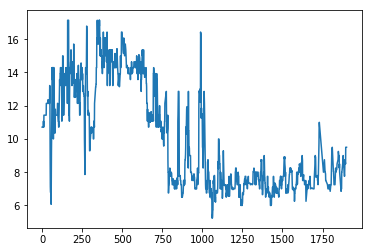

In [16]:
dataset, dates = data_tools.load_data_from_csv(const.DATA_DIR + "apple_interpolate.csv")
print("# shape: ", dataset.shape)

# plot
plt.plot(dataset)
plt.show()

## 数据转化与处理

In [17]:
# transform data to be stationary
diff_internal = 1
diff_series = data_tools.difference(dataset, diff_internal)
diff_values = diff_series.values
diff_values = diff_values.reshape(len(diff_values), 1)
print("# shape:", diff_values.shape)

# shape: (1900, 1)


In [18]:
# rescale values to -1, 1
scaler = data_tools.Po_MinMaxScaler
scaled_values = scaler.fit_transform(diff_values)
# scaled_values = scaled_values.reshape(len(scaled_values), 1)

# test series_to_supervised 1
# scaled_values = diff_values

C:\Users\demo\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
# transform into supervised learning problem X, y
n_lag = const.LOOK_BACK
n_seq = const.OUTPUT
supervised = data_tools.series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
print("# shape:", supervised_values.shape)

# split into train and test sets
n_test = int(len(supervised_values) * (1 - const.TRAIN_SCALE))
train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
print("# train, test length:", len(train), len(test))
print("# length:", len(diff_values) - n_lag == len(train) + len(test))  # single step

# test series_to_supervised 2
# for i in range(len(supervised_values)): 
#     if(not supervised_values[i][n_lag] - scaled_values[n_lag + i] < 0.0001):
#         print("BAD.")

# shape: (1870, 31)
# train, test length: 1497 373
# length: True


In [20]:
trainX, trainY = train[:, 0:n_lag], train[:, n_lag:]
testX, testY = test[:, 0:n_lag], test[:, n_lag:]
print(trainX.shape)
print(trainY.shape)

(1497, 30)
(1497, 1)


In [21]:
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix

# shuffle train set (include validation set)
trainX_sparse = coo_matrix(trainX)  # sparse matrix
trainX, trainX_sparse, trainY = shuffle(trainX, trainX_sparse, trainY, random_state=0)

## 建立 LSTM 模型

return_sequences：默认 False。在输出序列中，返回单个 hidden state值还是返回全部time step 的 hidden state值。 False 返回单个， true 返回全部。

To stack LSTM layers, we need to change the configuration of the prior LSTM layer to output a 3D array as input for the subsequent layer.

In [22]:
# reshape training into [samples, timesteps, features]
time_steps = n_lag
trainX = numpy.reshape(trainX, (trainX.shape[0], time_steps, trainX.shape[1]//time_steps)) 
testX = numpy.reshape(testX, (testX.shape[0], time_steps, testX.shape[1]//time_steps))
print(testX.shape)
print(testY.shape)

(373, 30, 1)
(373, 1)


In [23]:
n_dim = trainX.shape[2]
# create and fit the LSTM network
s, model = networks_factory.create_lstm_model(lstm_neurons=networks_factory.HIDDEN_NEURONS, 
                                              hidden_layers=networks_factory.HIDDEN_LAYERS, 
                                              lenth=time_steps, dims=n_dim, n_out=1)
# model = load_model(model_dir + "model.h5")

n_epoch = networks_factory.EPOCHS
n_batch_size = networks_factory.BATCH_SIZE
model_dir = const.EXPERIMENTS_DIR + "/apple/lstm_univariate/"

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=10, batch_size=n_batch_size, validation_split=const.VALIDATION_SCALE,
                    verbose=2, callbacks=[networks_factory.ES])  # verbose：debug信息

Train on 1122 samples, validate on 375 samples
Epoch 1/10
 - 4s - loss: 0.1202 - val_loss: 0.0049
Epoch 2/10
 - 3s - loss: 0.0040 - val_loss: 0.0044
Epoch 3/10
 - 3s - loss: 0.0033 - val_loss: 0.0043
Epoch 4/10
 - 3s - loss: 0.0032 - val_loss: 0.0042
Epoch 5/10
 - 3s - loss: 0.0032 - val_loss: 0.0043
Epoch 6/10
 - 2s - loss: 0.0032 - val_loss: 0.0043
Epoch 7/10
 - 2s - loss: 0.0033 - val_loss: 0.0048
Epoch 8/10
 - 2s - loss: 0.0032 - val_loss: 0.0042
Epoch 9/10
 - 2s - loss: 0.0033 - val_loss: 0.0044
Epoch 10/10
 - 3s - loss: 0.0033 - val_loss: 0.0042


In [24]:
print_summary(model)  # after the model was built

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 32)            4352      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


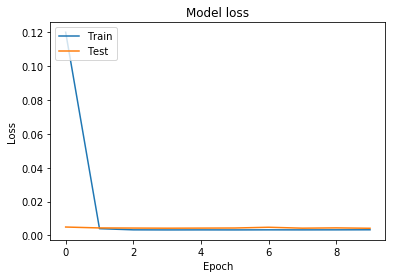

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 预测评估
Note that traing data are shuffled...

In [26]:
# for time's order
trainX, trainY = train[:, 0:n_lag], train[:, n_lag:]
trainX = numpy.reshape(trainX, (trainX.shape[0], time_steps, trainX.shape[1]//time_steps)) 

In [27]:
n_validate = int(len(trainX) * const.VALIDATION_SCALE)

# make a prediction
train_predict = model.predict(trainX)
validate_predict = train_predict[-n_validate:]
# invert predictions
inv_trainP = scaler.inverse_transform(train_predict)
inv_trainY = scaler.inverse_transform(trainY)
inv_validateP = inv_trainP[-n_validate:]
inv_validateY = inv_trainY[-n_validate:]

# invert trainPredict differencing
inv_diff_trainP = train_predict.copy()
# inv_diff_trainPredict = trainY.copy()  # test inv_diff's for loop; clear
for i in range(len(train_predict)):
    index = diff_internal + n_lag + i - 1  # 1 step forward
    inv_diff_trainP[i] = dataset[index] + inv_diff_trainP[i]
inv_diff_trainY = dataset[(diff_internal + n_lag):-n_test, :]

inv_diff_validateP = inv_diff_trainP[-n_validate:]
inv_diff_validateY = inv_diff_trainY[-n_validate:]

# calculate RMSE, MAPE, Dstat
train_rmse = math.sqrt(mean_squared_error(inv_diff_trainY, inv_diff_trainP))
validate_rmse = math.sqrt(mean_squared_error(inv_diff_validateY, inv_diff_validateP))
print('Train RMSE: %.4f, Validate RMSE: %.4f' % (train_rmse, validate_rmse))

train_mape = data_metrics.MAPE(inv_diff_trainY, inv_diff_trainP)
validate_mape = data_metrics.MAPE(inv_diff_validateY, inv_diff_validateP)
print('Train MAPE: %.4f, Validate MAPE: %.4f' % (train_mape, validate_mape))

train_ds = data_metrics.Dstat(inv_diff_trainY, inv_diff_trainP)
validate_ds = data_metrics.Dstat(inv_diff_validateY, inv_diff_validateP)
print('Train Dstat: %.4f, Validate Dstat: %.4f' % (train_ds, validate_ds))

Train RMSE: 0.7820, Validate RMSE: 0.5727
Train MAPE: 0.0637, Validate MAPE: 0.0722
Train Dstat: 0.6718, Validate Dstat: 0.7212


In [28]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
inv_trainP = scaler.inverse_transform(trainPredict)
inv_trainY = scaler.inverse_transform(trainY)
inv_testP = scaler.inverse_transform(testPredict)
inv_testY = scaler.inverse_transform(testY)

# invert trainPredict differencing
inv_diff_trainPredict = trainPredict.copy()
# inv_diff_trainPredict = trainY.copy()  # test inv_diff's for loop; clear
for i in range(len(trainPredict)):
    index = diff_internal + n_lag + i - 1  # 1 step forward
    inv_diff_trainPredict[i] = dataset[index] + inv_diff_trainPredict[i]
print("# shape", inv_diff_trainPredict.shape)
# print(inv_diff_trainPredict)
    
inv_diff_trainY = dataset[(diff_internal + n_lag):-n_test, :]
print("# shape", inv_diff_trainY.shape)
# print(inv_diff_trainY)

# invert testPredict differencing
inv_diff_testPredict = testPredict.copy()
# inv_diff_testPredict = testY.copy()  # test inv_diff's for loop; clear
for i in range(len(testPredict)):
    index = -n_test + i - 1  # 1 step forward
    inv_diff_testPredict[i] = dataset[index] + inv_diff_testPredict[i]
print("# shape", inv_diff_testPredict.shape)
# print(inv_diff_testPredict)
    
inv_diff_testY = dataset[-n_test:, :]
print("# shape", inv_diff_testY.shape)
# print(inv_diff_testY)

# shape (1497, 1)
# shape (1497, 1)
# shape (373, 1)
# shape (373, 1)


In [29]:
# calculate RMSE, MAPE, Dstat
train_rmse = math.sqrt(mean_squared_error(inv_diff_trainY, inv_diff_trainPredict))
test_rmse = math.sqrt(mean_squared_error(inv_diff_testY, inv_diff_testPredict))
print('Train RMSE: %.4f, Test RMSE: %.4f' % (train_rmse, test_rmse))

train_mape = data_metrics.MAPE(inv_diff_trainY, inv_diff_trainPredict)
test_mape = data_metrics.MAPE(inv_diff_testY, inv_diff_testPredict)
print('Train MAPE: %.4f, Test MAPE: %.4f' % (train_mape, test_mape))

train_ds = data_metrics.Dstat(inv_diff_trainY, inv_diff_trainPredict)
test_ds = data_metrics.Dstat(inv_diff_testY, inv_diff_testPredict)
print('Train Dstat: %.4f, Test Dstat: %.4f' % (train_ds, test_ds))

Train RMSE: 0.7820, Test RMSE: 0.5514
Train MAPE: 0.0637, Test MAPE: 0.0662
Train Dstat: 0.6718, Test Dstat: 0.6317


## 画出结果

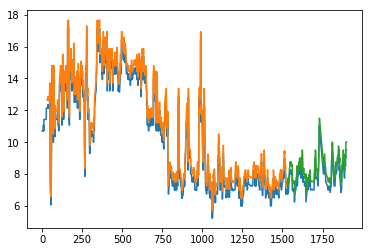

In [30]:
look_back = n_lag

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(inv_diff_trainPredict)+look_back, :] = inv_diff_trainPredict[:]  # 不包括len(trainPredict)+look_back

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(inv_diff_trainPredict)+look_back+1:len(dataset),:] = inv_diff_testPredict[:]
# 注意由于划分了训练集和测试集，总的samples数目会减少：len(dataset - lookback) - (len(trainX)+len(testX))

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Save Model

In [31]:
# 保存参数，载入参数
# model.save(model_dir + "model.h5")  # HDF5文件，pip install h5py
# model.save_weights(model_dir + "my_model_weights.h5")
# model.load_weights('my_model_weights.h5')

参考：[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/"Title")